# **Multilingual Hate Speech Detection**

Detect whether the comment is toxic for a multiligual toxic comment dataset.

Two methods has been used:

1.   Multilingual model from detoxify
2.   MBart Translation + BERTweet classification




## Prepare data

*   Download the file validation.csv from https://drive.google.com/drive/folders/1BIXtW5aH5Vf4rfRxo7EnLJB9izi_ZNBs?usp=sharing and upload it manually

*   The data is from https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification/data. Its validation dataset is used for test in this case. The dataset consists of id, content, lang(id) and toxic(0 or 1)



In [1]:
import pandas as pd
test_df = pd.read_csv('./validation.csv', header=0)

In [ ]:
test_df.head()

,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


In [ ]:
test_df.lang.unique()

array(['es', 'it', 'tr'], dtype=object)

## Method1: Multilingual model from Detoxify

Copyright: the model is from https://github.com/unitaryai/detoxify under Apache-2.0 License

In [ ]:
pip install detoxify

In [ ]:
from detoxify import Detoxify
Predictor = Detoxify('multilingual')

def predict_toxicity(df):
    df['pred_toxicity'] = round(Predictor.predict(df['comment_text'])['toxicity'])
    return df
test_df=test_df.apply(predict_toxicity, axis = 1)


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
def plot_cf(dataset):
  y_true = np.asarray(dataset['toxic'].to_list())
  y_pred = np.asarray(dataset['pred_toxicity'].to_list())
  cf_matrix=confusion_matrix(y_pred, y_true)
  import seaborn as sns
  heatmap = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True)
  plt.xlabel("True")
  plt.ylabel("Pred") 
  plt.title('Confusion matrix for hate speech detection. 0 means non-toxic and 1 means toxic')
  plt.show()

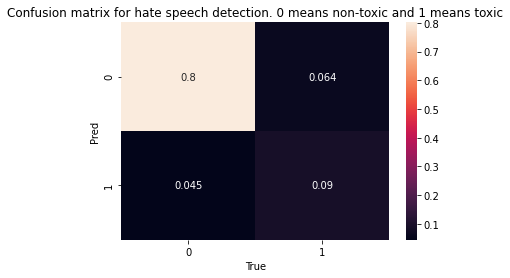

In [ ]:
# Plot the overall confusion matrix
plot_cf(dataset=test_df)

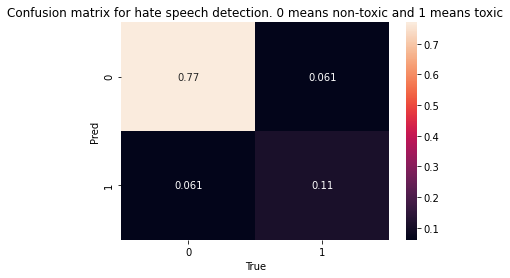

In [ ]:
# Plot confusion matrix for es
plot_cf(dataset=test_df[test_df.lang == 'es'])

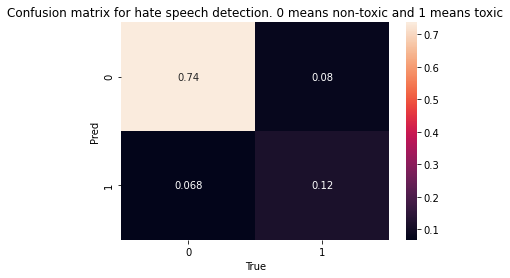

In [ ]:
# Plot confusion matrix for it
plot_cf(dataset=test_df[test_df.lang == 'it'])

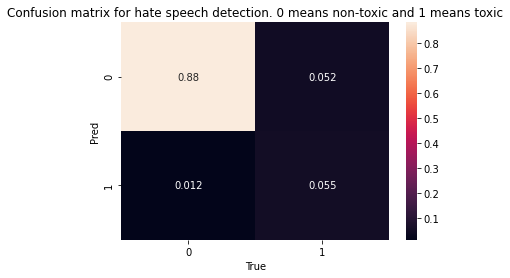

In [ ]:
# Plot confusion matrix for tr
plot_cf(dataset=test_df[test_df.lang == 'tr'])

## Method2: mBART + BERTweet

### Generate translation with mBART

To skip this part, comment it and load the data (translated.csv) manually from https://drive.google.com/drive/folders/1BIXtW5aH5Vf4rfRxo7EnLJB9izi_ZNBs?usp=sharing

In [2]:
pip install transformers==4.4.2 sentencepiece

     |████████████████████████████████| 2.0MB 8.8MB/s 
     |████████████████████████████████| 1.2MB 52.2MB/s 
     |████████████████████████████████| 890kB 50.3MB/s 
     |████████████████████████████████| 3.2MB 50.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=05772b88816c4190f635a81eb54fc393d80879ca47c8aa2b70a58efc09e7a945
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
import torch
mBART_50_lang_id = {'it':'it_IT', 'es':'es_XX', 'tr': 'tr_TR'}
modelMT = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
tokenizerMT = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")


In [4]:
def generate_translation(df, tgt_lang='en_XX'):
  src_lang = mBART_50_lang_id[df['lang']]
  text=df['comment_text']
  # print(text)
  tokenizerMT.src_lang = src_lang
  input_values = tokenizerMT(text, return_tensors='pt', padding=True)
  input_values = input_values.to(device)
  outputs = modelMT.generate(**input_values, forced_bos_token_id=tokenizerMT.lang_code_to_id[tgt_lang])
  translation = tokenizerMT.batch_decode(outputs, skip_special_tokens=True)[0]
  df['translation'] = translation
  # print(translation)
  return df
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
modelMT.to(device)
test_df = test_df.apply(generate_translation, axis=1)
test_df.to_csv('translated.csv')

In [ ]:
import pandas as pd
test_dt = pd.read_csv('./translated.csv')

### Hate speech detection
Download the BERTweet model from https://drive.google.com/drive/folders/1BIXtW5aH5Vf4rfRxo7EnLJB9izi_ZNBs?usp=sharing

NOte: The output of BERTweet has 3 labels: hate speech(0), offensive language(1) and either(2). 

In [ ]:
import pandas as pd
import torch
from transformers import AutoModel, AutoTokenizer
from torch import nn
from torch.utils.data import Dataset, DataLoader


class TweetsDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer, max_len):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        label = self.labels[item]

        input_ids = tokenizer.encode(tweet,
                                     padding='max_length',
                                     truncation=True,
                                     return_tensors='pt').squeeze()  # return_tensors='pt'

        return {'tweet': tweet, 'input_ids': input_ids,
                'label': torch.tensor(label, dtype=torch.long)
                }


# Data Loader
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TweetsDataset(
        tweets=df['translation'].to_numpy(),
        labels=df['toxic'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2
    )


class HSClassifier(nn.Module):
    def __init__(self, n_classes):
        super(HSClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/bertweet-base")
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids):  # , attention_mask):
        pooled_output = self.bert(
            input_ids=input_ids).pooler_output  # ['pooler_output']#, attention_mask=attention_mask)
        output = self.drop(pooled_output)
        return self.out(output)


test_df = pd.read_csv('/home/zl/Desktop/test_df2.csv')

tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Used device is {device}')
model = HSClassifier(3)
model.load_state_dict(torch.load('/home/zl/Desktop/BERTweet_exp1_epochs6_BatchSize32_best_model_state_BESTE.bin'))




In [ ]:
def predict_toxicity_3label(df):
    print(df['id'])
    input_ids = tokenizer.encode(df['translation'], return_tensors='pt', truncation=True)
    # input_ids = input_ids.to(device)
    outputs = model(input_ids)
    _, preds = torch.max(outputs, dim=1)
    result = preds.tolist()[0]
    if result == 2:
        #either label
        df['pred_toxicity'] = 0
    elif result == 1:
        #offensive label
        df['pred_toxicity'] = 9
    else:
        #hate label
        df['pred_toxicity'] = 1
    return df

test_df = test_df.apply(predict_toxicity_3label, axis=1)

test_df.to_csv('alldata_3label.csv')

In [ ]:
def predict_toxicity_2label(df):
    print(df['id'])
    input_ids = tokenizer.encode(df['translation'], return_tensors='pt', truncation=True)
    # input_ids = input_ids.to(device)
    outputs = model(input_ids)
    _, preds = torch.max(outputs, dim=1)
    result = preds.tolist()[0]
    if result == 2:
        df['pred_toxicity'] = 0
    else:
        df['pred_toxicity'] = 1
    return df
test_df = pd.read_csv('./translated.csv')
test_df = test_df.apply(predict_toxicity_2label, axis=1)
test_df.to_csv('alldata_2label.csv')

### Evaluation
The output of BERTweet has 3 labels: hate speech(0), offensive language(1) and either(2).
*   2label: toxic/non-toxic.Both hate and offensive are set as toxic
*   3label: offensive/toxic/non-toxic. Hate is set as toxicRemove offensive rows in calculating confusion metric.




In [2]:
import pandas as pd
test_df_3label = pd.read_csv('alldata_3label.csv')
test_df_2label = pd.read_csv('alldata_2label.csv')

In [3]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
def plot_cf(dataset):
  y_true = np.asarray(dataset['toxic'].to_list())
  y_pred = np.asarray(dataset['pred_toxicity'].to_list())

  cf_matrix=confusion_matrix(y_pred, y_true)
  import seaborn as sns
  heatmap = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True)
  plt.xlabel("True")
  plt.ylabel("Pred")
  # plt.title('Confusion matrix for hate speech detection. 0 means non-toxic and 1 means toxic')
  plt.show()

#### 2 label

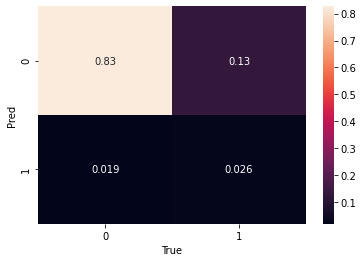

In [4]:
plot_cf(test_df_2label)

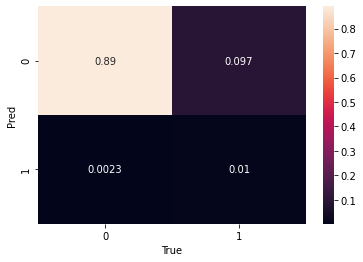

In [5]:
plot_cf(dataset=test_df_2label[test_df_2label.lang == 'tr'])

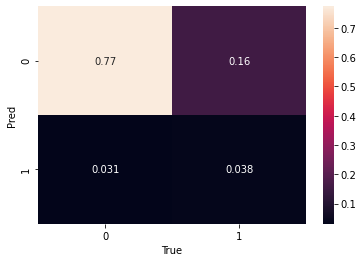

In [6]:
plot_cf(dataset=test_df_2label[test_df_2label.lang == 'it'])

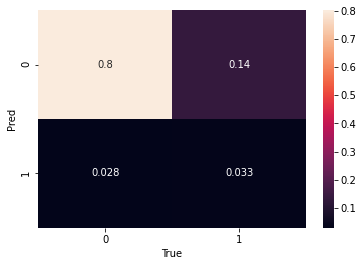

In [7]:
plot_cf(dataset=test_df_2label[test_df_2label.lang == 'es'])

#### 3 label


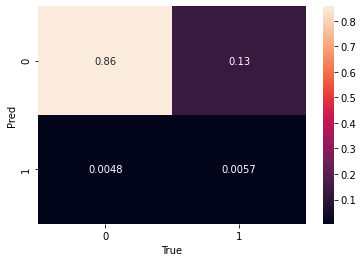

In [8]:
# Remove offensive speech
test_df_3label = test_df_3label.drop(test_df_3label[test_df_3label.pred_toxicity==9].index) # 7432 remaining
plot_cf(test_df_3label)


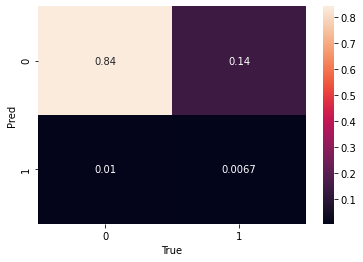

In [9]:
plot_cf(dataset=test_df_3label[test_df_3label.lang == 'es'])

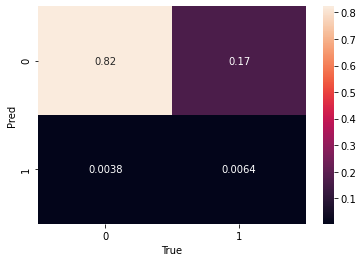

In [10]:
plot_cf(dataset=test_df_3label[test_df_3label.lang == 'it'])

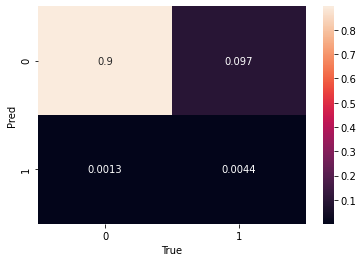

In [11]:
plot_cf(dataset=test_df_3label[test_df_3label.lang == 'tr'])